In [40]:
%matplotlib notebook
import pandas as pd
import matplotlib.pyplot as plt
from scipy import ndimage, misc
import numpy as np
import numpy.matlib as matlib
import glob
import re
import os
import tensorflow as tf
import sys
import pickle
sess = tf.InteractiveSession()

In [49]:
def downsampleByTwo(img):
        tmp = np.array(img)
        # if the number of rows is odd, pad with a row of zeros
        if (tmp.shape[0] & 0x01):
            tmp = np.vstack([tmp, np.zeros((1, tmp.shape[1]))])

        if (tmp.shape[1] & 0x01):
            tmp = np.hstack([tmp, np.zeros((tmp.shape[0], 1))])

        ret = np.zeros(np.array(tmp.shape) / 2)

        for i in range(tmp.shape[0]):
            for j in range(tmp.shape[1]):
                ret[i/2,j/2] = .25 * tmp[i,j]

        return ret

def preprocessImage(img):
#     edges = ndimage.filters.sobel(img)
#     opening = ndimage.morphology.binary_opening(edges, structure=np.ones((2,2)))
    blurred = ndimage.gaussian_filter(img, 3)
    ds = downsampleByTwo(blurred)
    ds = downsampleByTwo(ds)
    ds = downsampleByTwo(ds)
    return ds

def readInFile(fName):
    data = pd.read_csv(fName, index_col=0, dtype='object')

    ret = []
    
    isTestSet = False
    if 'species' in data:
        isTestSet = True

    marginCols = ['margin{0}'.format(i) for i in range(1, 65)]
    textureCols = ['texture{0}'.format(i) for i in range(1, 65)]
    shapeCols = ['shape{0}'.format(i) for i in range(1, 65)]

    labelMap = None
    if isTestSet:
        ## Generate one hot encoding for species
        classNames = sorted(np.unique(data['species']))
        numClasses = len(classNames)
        labelMap = {k:i for i,k in enumerate(classNames)}

    

    columnGroups = [marginCols, textureCols, shapeCols]
    for r in data.iterrows():
        caseId = r[0]
        print '\r','{0:4d}'.format(caseId),
        sys.stdout.flush()
        ret.append([caseId])
        
        if isTestSet:
            # Generate one hot encoding for species
            oneHot = np.zeros((numClasses,))
            oneHot[labelMap[r[1]['species']]] = 1.0
            classId = labelMap[r[1]['species']]
            ret[-1].append(classId)
            ret[-1].append(oneHot)

        for col in columnGroups:
            curr = r[1][col]
            ret[-1].append(np.array([float(x) for x in curr]))

        img = ndimage.imread('data/images/{0}.jpg'.format(caseId)) / 255.0
        img = preprocessImage(img)
        ret[-1].append(img)
        ret[-1].append(img.shape[0])
        ret[-1].append(img.shape[1])
        
    columns = ['caseId', 'classId', 'oneHot', 'margin', 
               'textureCols', 'shape', 'img', 'height', 
               'width']
    if not isTestSet:
        columns = columns[:1] + columns[3:]
    return pd.DataFrame(ret, columns=columns), labelMap
    

if not os.path.exists('trainingData.p'):
    trainData, labelMap = readInFile('data/train.csv')
    testData, _ = readInFile('data/test.csv')
    
    pd.to_pickle(trainData, 'trainingData.p')
    pd.to_pickle(testData, 'testingData.p')
    with open('labelMap.p','w') as fileOut:
        pickle.dump(labelMap, fileOut)
else:
    trainData = pd.read_pickle('trainingData.p')
    testData = pd.read_pickle('testingData.p')
    with open('labelMap.p', 'r') as fileIn:
        labelMap = pickle.load(fileIn)
    
class LeafData:
    '''
    Takes in a dataframe of samples
    '''
    def __init__(self, data, testSplit=.3, numClasses=None, isTest=False):
        self._isTest = isTest
        if not self._isTest:
            if numClasses:
                self.numClasses = numClasses
            else:
                self.numClasses = np.max(data.iloc[0]['oneHot'].shape)
            
            data = data[data['classId'] < self.numClasses]
        else:
            testSplit=1.0
        
        numItems = len(data)
        numTestItems = int(numItems * testSplit)
        testSelector = np.random.choice(numItems, numTestItems,
                                        replace=False)
        self._testCases = data.iloc[testSelector].copy(deep=True)
        trainCaseSelector = list(set(range(numItems)) - set(testSelector))
        self._trainCases = data.iloc[trainCaseSelector].copy(deep=True)
                
        self._trainIndex = 0
        
        self._maxWidth = np.max(data['width'])
        self._maxHeight = np.max(data['height'])

        # Define the height as around twice the max image height/width
        # but make sure it's divisible by 4
        self.normImgWidth = 64
        self.normImgHeight = 64
        
        # Combine the shape, texture and margin columns
        self._trainCases['mergedData'] = self._mergeMarginTextureShape(self._trainCases)
        self._testCases['mergedData'] = self._mergeMarginTextureShape(self._testCases)
        
        self.mergedDataLength = len(self._testCases.iloc[0]['mergedData'])
        
        if not self._isTest:
            self._genImageWhitenTransform()
            self._genHistWhitenTransform()

    def _mergeMarginTextureShape(self, cases):
        histData = []
        for r in cases.iterrows():
            caseId = r[0]
            data = r[1]
            histData.append(np.hstack([data[x] for x in ['margin', 'textureCols', 'shape']]))
        return histData
    
    def _genImageWhitenTransform(self):
        numImages = 10000
        img, _, y = self.getTrainBatch(numImages)
        img = np.reshape(img, [-1, self.normImgHeight * self.normImgWidth])
        img = img.T
        self._imgWhitenMeans = np.expand_dims(np.mean(img, axis=-1), -1)
        img = img - np.matlib.repmat(self._imgWhitenMeans, 1, numImages)
        self._covar = img.dot(img.T)
        
        w, v = np.linalg.eigh(self._covar)
        maxEigval = w[-1]
        ratio = 1e-2
        numEigVals = np.sum(w > maxEigval * ratio)
        w_r = w[-numEigVals:]
        v_r = v[:, -numEigVals:]

        self._imgWhitenFilter = np.sqrt(numImages-1) * v_r.dot(np.diag(w_r ** -.5)).dot(v_r.T)
        self._imgDewhitenFilter = 1/np.sqrt(numImages-1) * v_r.dot(np.diag(w_r ** .5)).dot(v_r.T)
    
    def _genHistWhitenTransform(self):
        ## TODO: Change this to use the 'mergedData' column
        histData = []
        for r in self._trainCases.iterrows():
            caseId = r[0]
            data = r[1]
            histData.append(np.hstack([data[x] for x in ['margin', 'textureCols', 'shape']]))

        histData = np.array(histData).T
        numSamples = len(self._trainCases)
        self._histWhitenMean = np.expand_dims(np.mean(histData, axis =-1), -1)
        histZeroMean = histData - np.matlib.repmat(self._histWhitenMean, 1, numSamples)
        histCovar = histZeroMean.dot(histZeroMean.T)
        w, v = np.linalg.eigh(histCovar)

        maxEigVal = w[-1]
        ratio = 1e-2
        numEigVals = np.sum(w > w[-1] * ratio)
        w_r = w[-numEigVals:]
        v_r = v[:,-numEigVals:]

        self._histWhitenFilter = np.sqrt(numSamples-1) * v_r.dot(np.diag(w_r ** -.5)).dot(v_r.T)
        self._histDewhitenFilter = 1/np.sqrt(numSamples-1) * v_r.dot(np.diag(w_r ** .5)).dot(v_r.T)      

    def whitenImageSamples(self, img):
        tmp = np.reshape(img, (-1, self.normImgHeight * self.normImgWidth))
        tmp = tmp.T
        zeroMean = tmp - np.matlib.repmat(self._imgWhitenMeans, 1, tmp.shape[1])
        whitened = self._imgWhitenFilter.dot(zeroMean)
        tmp = whitened.T
        return np.reshape(tmp, (-1, self.normImgHeight, self.normImgWidth))
    
    def whitenHistSamples(self, hist):
        tmp = hist.T
        zeroMean = tmp - np.matlib.repmat(self._histWhitenMean, 1, tmp.shape[1])
        whitened = self._histWhitenFilter.dot(zeroMean)
        return whitened.T

    def getTrainBatch(self, n):
        y = np.zeros((n, self.numClasses))
        img = np.zeros((n, self.normImgHeight, self.normImgWidth))
        merged = np.zeros((n, self.mergedDataLength))
        
        for i in range(n):
            if self._trainIndex >= len(self._trainCases):
                self._trainIndex = 0
                self._trainCases = self._trainCases.sample(frac=1.0)

            currCase = self._trainCases.iloc[self._trainIndex]
            currImg = np.squeeze(currCase['img'])
            rot = np.random.random(1) * 360
            currImg = ndimage.rotate(currImg, rot)
            imgHeight = currImg.shape[0]
            imgWidth = currImg.shape[1]

            
            maxDim = np.max([imgHeight, imgWidth])
            tmpImg = np.zeros((maxDim, maxDim))
            
            lrShift = (maxDim - imgWidth) / 2
            udShift = (maxDim - imgHeight) / 2
            tmpImg[udShift:udShift+imgHeight, lrShift:lrShift+imgWidth] = currImg
            
            targetSize = (float(self.normImgHeight) / maxDim, float(self.normImgWidth) / maxDim)
            tmpImg = ndimage.zoom(tmpImg, targetSize)

            img[i, :, :] = tmpImg

            y[i, :] = currCase['oneHot'][:self.numClasses]
            merged[i,:] = currCase['mergedData']
            
            self._trainIndex += 1
            
            
        return img, merged, y
    
    def getTestData(self):
        y = None
        if not self._isTest:
            y = np.zeros((len(self._testCases), self.numClasses))
        img = np.zeros((len(self._testCases), self.normImgHeight, self.normImgWidth))
        merged = np.zeros((len(self._testCases), self.mergedDataLength))
        for i in range(len(self._testCases)):
            currCase = self._testCases.iloc[i]
            imgHeight = currCase['height']
            imgWidth = currCase['width']
            
            maxDim = np.max([imgHeight, imgWidth])
            tmpImg = np.zeros((maxDim, maxDim))
            lrShift = (maxDim - imgWidth) / 2
            udShift = (maxDim - imgHeight) / 2
            tmpImg[udShift:udShift+imgHeight, lrShift:lrShift+imgWidth] = currCase['img']
            
            targetSize = (float(self.normImgHeight) / maxDim, float(self.normImgWidth) / maxDim)
            img[i, :, :] = ndimage.zoom(tmpImg, targetSize)

            if not self._isTest:
                y[i, :] = currCase['oneHot'][:self.numClasses]
            merged[i, :] = currCase['mergedData']
            self._trainIndex += 1
            
        return img, merged, y
        
        
data = LeafData(trainData, testSplit=.3)
test = LeafData(testData, isTest=True)


In [ ]:
img, y = data.getTrainBatch(9)
whitened = data.whitenSamples(img)
plt.figure()
for i in range(img.shape[0]):
    plt.subplot(img.shape[0], 2, 2*i + 1)
    plt.imshow(img[i,:,:], cmap='gray')
    plt.subplot(img.shape[0], 2, 2*i + 2)
    plt.imshow(whitened[i,:,:], cmap='gray')

Defining Graph
Conv2D x Tensor("imgPlaceHolder_29:0", shape=(?, 64, 64, 1), dtype=float32)
Conv2D W Tensor("w_conv1_29/read:0", shape=(3, 3, 1, 32), dtype=float32)
Max_pool x Tensor("pool1_relu_29:0", shape=(?, 64, 64, 32), dtype=float32)
convLayer pool Tensor("pool1_maxPool_29:0", shape=(?, 32, 32, 32), dtype=float32)
Conv2D x Tensor("pool1_maxPool_29:0", shape=(?, 32, 32, 32), dtype=float32)
Conv2D W Tensor("w_conv2_29/read:0", shape=(3, 3, 32, 64), dtype=float32)
Max_pool x Tensor("pool2_relu_29:0", shape=(?, 32, 32, 64), dtype=float32)
convLayer pool Tensor("pool2_maxPool_29:0", shape=(?, 16, 16, 64), dtype=float32)
Conv2D x Tensor("pool2_maxPool_29:0", shape=(?, 16, 16, 64), dtype=float32)
Conv2D W Tensor("w_conv3_29/read:0", shape=(3, 3, 64, 64), dtype=float32)
Max_pool x Tensor("pool3_relu_29:0", shape=(?, 16, 16, 64), dtype=float32)
convLayer pool Tensor("pool3_maxPool_29:0", shape=(?, 8, 8, 64), dtype=float32)
8 8
pool_flat Tensor("flatten_26:0", shape=(?, 4096), dtype=float32

<IPython.core.display.Javascript object>


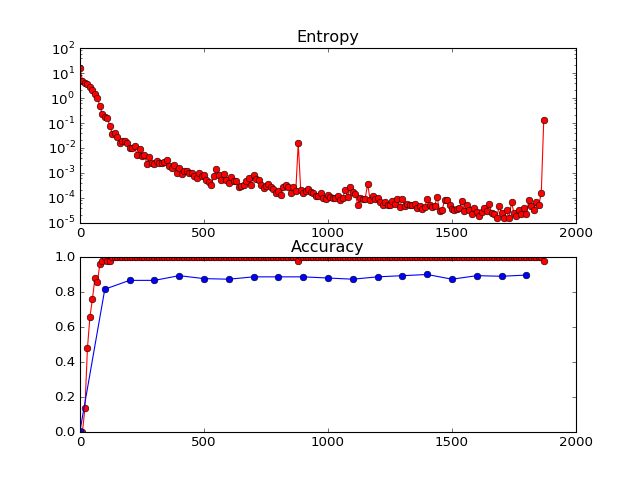

Starting Learning


KeyboardInterrupt: 

In [58]:

learningRate = 1e-3

print 'Defining Graph'

def weight_variable(shape, name=None): 
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial, name=name)

def bias_variable(shape, name=None):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial, name=name)

def conv2d(x, W, name=None):
    print 'Conv2D x', x
    print 'Conv2D W', W
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME', name=name)

def max_pool_2x2(x, name=None):
    print 'Max_pool x', x
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1],
                          padding='SAME', name=name)

def convLayer(x, w, b, name=None):
    conv = tf.nn.relu(conv2d(x, w, name=name+'_conv2d') + b, name=name+'_relu')
    pool = max_pool_2x2(conv, name=name+'_maxPool')
    print 'convLayer pool', pool
    return pool

x = tf.placeholder(tf.float32, shape=[None, data.normImgHeight, data.normImgWidth, 1], name='imgPlaceHolder')
labels = tf.placeholder(tf.float32, shape=[None, data.numClasses], name='labelPlaceHolder')
hists = tf.placeholder(tf.float32, shape=[None, data.mergedDataLength], name='histogramInfo')

## Layer definitions
# Layer 1 - Convolutional
kernelSize = 3
numOutputs = 32
numInputChannels = 1
W_conv1 = weight_variable([kernelSize, kernelSize, 
                           numInputChannels, numOutputs], name='w_conv1')
b_conv1 = bias_variable([numOutputs], name='b_conv1')

pool1 = convLayer(x, W_conv1, b_conv1, name='pool1')

outputWidth = data.normImgWidth / 2
outputHeight = data.normImgHeight / 2

# Layer 2 - Convolutional
kernelSize = 3
numInputChannels = numOutputs
numOutputs = 64

W_conv2 = weight_variable([kernelSize, kernelSize,
                           numInputChannels, numOutputs], name='w_conv2')
b_conv2 = bias_variable([numOutputs], name='b_conv2')

pool2 = convLayer(pool1, W_conv2, b_conv2, name='pool2')

outputWidth = outputWidth / 2
outputHeight = outputHeight / 2

# Layer 3 - Convolutional
kernelSize = 3
numInputChannels = numOutputs
numOutputs = 64

W_conv3 = weight_variable([kernelSize, kernelSize,
                           numInputChannels, numOutputs], name='w_conv3')
b_conv3 = bias_variable([numOutputs], name='b_conv3')

pool3 = convLayer(pool2, W_conv3, b_conv3, name='pool3')

outputWidth = outputWidth / 2
outputHeight = outputHeight / 2

# # # Layer 4 - Convolutional
# kernelSize = 3
# numInputChannels = numOutputs
# numOutputs = 32

# W_conv4 = weight_variable([kernelSize, kernelSize,
#                            numInputChannels, numOutputs], name='w_conv4')
# b_conv4 = bias_variable([numOutputs], name='b_conv4')

# pool4 = convLayer(pool3, W_conv4, b_conv4, name='pool4')

# outputWidth = outputWidth / 2
# outputHeight = outputHeight / 2

####
#### Layers for histogram
####

# Fully connected layer 1
numHistNeuronsOutput = 128
w_hist1 = weight_variable([data.mergedDataLength, numHistNeuronsOutput], name='w_hist1')
b_hist1 = bias_variable([numHistNeuronsOutput], name='b_hist1')
fcHist1 = tf.nn.relu(tf.matmul(hists, w_hist1, name='fcHist1_matmul') + b_hist1, name='fcHist1_relu')

w_hist2 = weight_variable([numHistNeuronsOutput, numHistNeuronsOutput], name='w_hist2')
b_hist2 = bias_variable([numHistNeuronsOutput], name='b_hist2')
fcHist2 = tf.nn.relu(tf.matmul(fcHist1, w_hist2, name='fcHist2_matmul') + b_hist2, name='fcHist2_relu')


####
####
####

# Layer 4 - Fully connected
fcNeurons = 1024
print outputWidth, outputHeight

W_fc1 = weight_variable([outputWidth * outputHeight *numOutputs + numHistNeuronsOutput, fcNeurons], name='w_fc1')
b_fc1 = bias_variable([fcNeurons], name='b_fc1')
# 
# dummy = tf.concat(0, [pool3, weight_variable([1, 8, 8, 64])], name='combined')

pool_flat = tf.reshape(pool3, [-1, outputWidth * outputHeight * numOutputs], name='flatten')
print 'pool_flat', pool_flat, pool_flat.get_shape()
print 'fcHist2', fcHist2
combined = tf.concat(1, [pool_flat, fcHist2], name='combined')
print 'combined', combined
fc1 = tf.nn.relu(tf.matmul(combined, W_fc1, name='fc1_matmul') + b_fc1, name='fc1_relu')

# fc1 = tf.nn.relu(tf.matmul(pool_flat, W_fc1, name='fc1_matmul') + b_fc1, name='fc1_relu')
print 'Pool3', pool3
print 'Pool3_flat', pool_flat, outputWidth, outputHeight, numOutputs


# # Layer 4 - Fully connected
# fcNeurons = 512
# print outputWidth, outputHeight
# W_fc2 = weight_variable([outputWidth * outputHeight * numOutputs, fcNeurons], name='w_fc2')
# b_fc2 = bias_variable([fcNeurons], name='b_fc2')

# fc2 = tf.nn.relu(tf.matmul(fc1, W_fc2, name='fc2_matmul') + b_fc2, name='fc2_relu')

# Layer 4 - Dropout
keep_prob = tf.placeholder(tf.float32, name='keep_prob')
dropout = tf.nn.dropout(fc1, keep_prob, name='dropoutLayer')

# Layer 5 - Readout
W_fc2 = weight_variable([fcNeurons, data.numClasses], name='w_fc2')
b_fc2 = bias_variable([data.numClasses], name='b_fc2')
y_conv = tf.matmul(dropout, W_fc2, name='y_conv') + b_fc2



# Define loss function
print 'Defining Loss Function'
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_conv, labels=labels, name='sm_cewl'))
train_step = tf.train.AdamOptimizer(learningRate).minimize(cross_entropy)

correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(labels,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

print 'Initializing Vars'
sess.run(tf.global_variables_initializer())

def softmax(w):
    w = np.array(w)

    maxes = np.amax(w, axis=1)
    maxes = maxes.reshape(maxes.shape[0], 1)
    e = np.exp(w - maxes)
    summed = np.sum(e, axis=1)
    div = np.vstack([summed] * w.shape[1]).T
    dist = e / div
    return dist
    
fig = plt.figure()
trainX = []
entropy = []
trainAccuracy = []
testAccuracy = []
entropyLine = None
trainAccLine = None
testAccLine = None

testImg, testHist, testY = data.getTestData()
whitenedTestImg = data.whitenImageSamples(testImg)
whitenedTestImg = np.expand_dims(whitenedTestImg, -1)
whitenedTestHist = data.whitenHistSamples(testHist)
testX = []

print 'Starting Learning'
for i in range(10000):
    img, hist, y = data.getTrainBatch(50)
    whitenedImg = data.whitenImageSamples(img)
    whitenedImg = np.expand_dims(whitenedImg, -1)
    whitenedHist = data.whitenHistSamples(hist)
    if i % 10 == 0:
        trainX.append(i)
        trainAccuracy.append(accuracy.eval(feed_dict={
            x: whitenedImg,
            labels: y,
            hists: whitenedHist,
            keep_prob: 1.0
        }))
        
        entropy.append(cross_entropy.eval(feed_dict={
            x: whitenedImg,
            labels: y,
            hists: whitenedHist,
            keep_prob: 1.0
        }))
        
        ax = plt.subplot(211)
        if entropyLine:
            entropyLine.set_ydata(entropy)
            entropyLine.set_xdata(trainX)
        else:
            entropyLine, = plt.semilogy(entropy,'ro-')
            plt.title('Entropy')
        ax.relim()
        ax.autoscale_view()

        ax = plt.subplot(212)
        if trainAccLine:
            trainAccLine.set_ydata(trainAccuracy)
            trainAccLine.set_xdata(trainX)
        else:
            trainAccLine, = plt.plot(np.array(trainAccuracy),'ro-')
            plt.title('Accuracy')
        ax.relim()
        ax.autoscale_view()
        fig.canvas.draw()
    if i % 100 == 0:
        testAccuracy.append(accuracy.eval(feed_dict={
            x: whitenedTestImg,
            labels:testY,
            hists: whitenedTestHist,
            keep_prob: 1.0
        }))
        testX.append(i)
        plt.subplot(212)
        if testAccLine:
            testAccLine.set_ydata(testAccuracy)
            testAccLine.set_xdata(testX)
        else:
            testAccLine, = plt.plot(testAccuracy, 'bo-')
        ax.relim()
        ax.autoscale_view()
        fig.canvas.draw()
        
    train_step.run(feed_dict={
        x: whitenedImg,
        labels: y,
        hists: whitenedHist,
        keep_prob: 0.5
    })


In [38]:
saver = tf.train.Saver()

In [39]:
saver.save(sess, 'trainedModel.ckpt')

'trainedModel.ckpt'

In [57]:
saver.restore(sess, 'trainedModel.ckpt')

testImg, testMerged, _ = test.getTestData()
whitenedTestImg = data.whitenImageSamples(testImg)
whitenedTestImg = np.expand_dims(whitenedTestImg, -1)
whitenedTestHist = data.whitenHistSamples(testMerged)

results = y_conv.eval(feed_dict={
    x: whitenedTestImg,
    hists: whitenedTestHist,
    keep_prob: 1.0
})

NotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for trainedModel.ckpt
	 [[Node: save/RestoreV2_990 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/cpu:0"](_recv_save/Const_0, save/RestoreV2_990/tensor_names, save/RestoreV2_990/shape_and_slices)]]

Caused by op u'save/RestoreV2_990', defined at:
  File "/usr/local/Cellar/python/2.7.11/Frameworks/Python.framework/Versions/2.7/lib/python2.7/runpy.py", line 162, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/local/Cellar/python/2.7.11/Frameworks/Python.framework/Versions/2.7/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/lib/python2.7/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/usr/local/lib/python2.7/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/usr/local/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-38-18da33d742f9>", line 1, in <module>
    saver = tf.train.Saver()
  File "/usr/local/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 1000, in __init__
    self.build()
  File "/usr/local/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 1030, in build
    restore_sequentially=self._restore_sequentially)
  File "/usr/local/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 624, in build
    restore_sequentially, reshape)
  File "/usr/local/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 361, in _AddRestoreOps
    tensors = self.restore_op(filename_tensor, saveable, preferred_shard)
  File "/usr/local/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 200, in restore_op
    [spec.tensor.dtype])[0])
  File "/usr/local/lib/python2.7/site-packages/tensorflow/python/ops/gen_io_ops.py", line 441, in restore_v2
    dtypes=dtypes, name=name)
  File "/usr/local/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 759, in apply_op
    op_def=op_def)
  File "/usr/local/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 2240, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/usr/local/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1128, in __init__
    self._traceback = _extract_stack()

NotFoundError (see above for traceback): Unsuccessful TensorSliceReader constructor: Failed to find any matching files for trainedModel.ckpt
	 [[Node: save/RestoreV2_990 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/cpu:0"](_recv_save/Const_0, save/RestoreV2_990/tensor_names, save/RestoreV2_990/shape_and_slices)]]


ValueError: Cannot feed value of shape (594, 64, 64) for Tensor u'imgPlaceHolder_28:0', which has shape '(?, 64, 64, 1)'

In [11]:
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [12]:
show_graph(tf.get_default_graph().as_graph_def())